In [1]:
%cd /users/anglos/Developer/psiphi

/auto/users/anglos/Developer/psiphi


In [2]:
#@title Imports
import jax
import tree

import social_rl

In [3]:
#@title Constants, experiment config.
GOAL_COLOR = 'red'
NUM_LEARNING_STEPS = 10_000
BATCH_SIZE = 128
DATA_DIR = 'data'
EXPERT_EPSILON = 0.05

In [4]:
#@title Collect expert data.
if False:
  %run experiments/collect_rollouts.py --config=experiments/configs/collect_rollouts.py:{GOAL_COLOR}

In [5]:
#@title Initialise environment, agent and offline dataset.
env = social_rl.GridWorld(goal_color=GOAL_COLOR)
replay_buffer = social_rl.DemonstrationsBuffer(
  data_dir='{}/{}/{}'.format(DATA_DIR, GOAL_COLOR, EXPERT_EPSILON), seed=42)
agent = social_rl.agents.BCAgent(env)
# Initialise the agent's learner.
rng_key = jax.random.PRNGKey(42)
rng_key, params_key = jax.random.split(rng_key, num=2)
params = agent.initial_params(params_key)
rng_key, learner_key = jax.random.split(rng_key, num=2)
learner_state = agent.initial_learner_state(learner_key, params)

100%|██████████| 1000/1000 [00:01<00:00, 573.55it/s]


step   9999 | TRAIN: accuracy: 0.99 | global_gradient_norm: 0.01 | loss: 0.03: 100%|██████████| 10000/10000 [01:39<00:00, 100.31it/s]


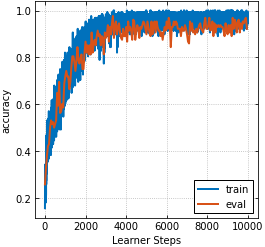

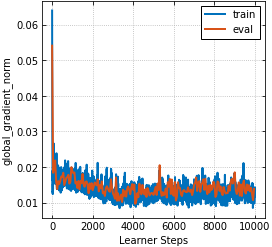

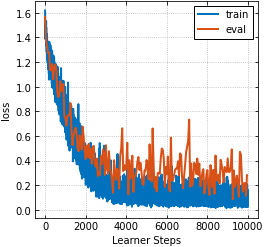

In [6]:
#@title Train agent on offline dataset.

params, learner_state, learner_stats = social_rl.loops.run_offline_learner_loop(
    rng_key,
    params,
    learner_state,
    agent.learner_step,
    replay_buffer,
    num_steps=NUM_LEARNING_STEPS,
    batch_size=BATCH_SIZE,
    evaluate_every=50)
social_rl.plotting.plot_stats(learner_stats);

In [7]:
#@title Evaluate agent online.
def evaluate(env: social_rl.GridWorld) -> float:
  """Return the success rate on `env`."""
  actor_stats = social_rl.loops.run_actor_loop(
    jax.random.PRNGKey(42),
    params,
    agent.actor_step,
    agent.initial_actor_state,
    env,
    num_episodes=500,
    evaluation=False)
  return (actor_stats['returns'] == 1.0).sum() / len(actor_stats['returns'])

environments = {
    goal_color: social_rl.GridWorld(goal_color=goal_color, seed=42)
    for goal_color in ('red', 'green', 'blue')
}
tree.map_structure(evaluate, environments)

  0%|          | 0/500 [00:00<?, ?it/s]/scratch/anglos/conda_envs/psiphi/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
100%|██████████| 500/500 [00:02<00:00, 212.17it/s]


{'red': 0.206, 'green': 0.078, 'blue': 0.058}